<div style="border:2px solid #89CFF0; padding:20px; border-radius:12px; background-color:grey;">
  <h1 style="color:#89CFF0;">DEPI Graduation Project: Object Detection for Autonomous Vehicles</h1>
  <p style="font-size:16px;">
    This notebook presents a complete end-to-end pipeline for object detection using <strong>YOLOv11</strong> on the <strong>KITTI dataset</strong>.
    The model is designed to detect and classify objects critical to autonomous driving such as <em>cars, pedestrians, cyclists, vans, and trucks</em>.
  </p>

  <h2 style="color:#89CFF0;">Project Objectives</h2>
  <ul style="font-size:15px;">
    <li>Convert KITTI annotations to YOLO-compatible format</li>
    <li>Apply data augmentation and organize the dataset for training and validation</li>
    <li>Train a custom YOLOv11 object detection model</li>
    <li>Evaluate performance metrics and log experiments with MLflow</li>
    <li>Export and visualize model predictions</li>
  </ul>

  <h2 style="color:#89CFF0;">Tools & Libraries</h2>
  <ul style="font-size:15px;">
    <li><strong>YOLOv11</strong> (via Ultralytics) for deep learning-based object detection</li>
    <li><strong>Albumentations</strong> for fast and flexible image augmentation</li>
    <li><strong>MLflow</strong> for experiment tracking and model versioning</li>
    <li><strong>OpenCV, Matplotlib, Seaborn</strong> for image handling and visualization</li>
  </ul>

  <h2 style="color:#89CFF0;">Dataset</h2>
  <p style="font-size:15px;">
    The <strong>KITTI Object Detection Benchmark</strong> is used for this project. It provides real-world annotated images captured from self-driving vehicles in various traffic environments.
  </p>
</div>


# Install Dependencies
This cell installs all the required Python packages for data processing, augmentation, model training, and experiment tracking including:
- `albumentations` for data augmentation,
- `ultralytics` for YOLOv11,
- `opencv-python`, `numpy`, and `tqdm` for processing and progress display,
- `mlflow` for tracking experiments.


In [1]:
!pip install albumentations --quiet
!pip install ultralytics opencv-python numpy tqdm --quiet
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 whic

# Import Libraries
All the necessary Python modules are imported here including image processing (PIL, OpenCV), augmentation (Albumentations), modeling (Ultralytics YOLO), and tracking (MLflow).


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from tqdm import tqdm
import cv2
from collections import Counter
import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from ultralytics import YOLO
import time
import yaml
import mlflow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Configuration Setup
Define core parameters like dataset paths, image size, number of epochs, and class names. Then, prepare directory structure for YOLO-compatible image and label folders.


In [3]:
# Configuration
CONFIG = {
    'kitti_path': '/kaggle/input/kitti-dataset',
    'img_size': 416,  # YOLO input size
    'train_split': 0.8,
    'batch_size': 16,  # Adjusted for stability
    'epochs': 120,  # Increased for better training
    'classes': ['Car', 'Pedestrian', 'Cyclist', 'Truck', 'Van'],
    'img_dims': {'width': 1242, 'height': 375},  # KITTI default
    'output_path': '/kaggle/working/yolo_dataset',
}

# Directory setup
kitti_images_dir = os.path.join(CONFIG['kitti_path'], 'data_object_image_2/training/image_2')
kitti_labels_dir = os.path.join(CONFIG['kitti_path'], 'data_object_label_2/training/label_2')

yolo_dataset_path = CONFIG['output_path']
yolo_images_train = os.path.join(yolo_dataset_path, 'images/train')
yolo_images_val = os.path.join(yolo_dataset_path, 'images/val')
yolo_labels_train = os.path.join(yolo_dataset_path, 'labels/train')
yolo_labels_val = os.path.join(yolo_dataset_path, 'labels/val')

for path in [yolo_images_train, yolo_images_val, yolo_labels_train, yolo_labels_val]:
    os.makedirs(path, exist_ok=True)

# Data Preprocessing and Exploration 

## Data Augmentation
Define an augmentation pipeline using Albumentations to improve model generalization. It includes flips, brightness/contrast adjustment, rotation, cropping, and normalization.


In [4]:
# Data augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=15, p=0.3),
    A.RandomCrop(height=CONFIG['img_size'], width=CONFIG['img_size'], p=0.2),
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

## Convert KITTI Annotations to YOLO Format
This function takes KITTI label files and converts them to YOLO format, writing the result to the corresponding label directory.


In [5]:
# Convert KITTI to YOLO format
def convert_kitti_to_yolo(label_file, img_file, split='train'):
    img_path = os.path.join(kitti_images_dir, img_file)
    img = Image.open(img_path)
    img_width, img_height = img.size
    img.close()

    with open(os.path.join(kitti_labels_dir, label_file), 'r') as f:
        lines = f.readlines()

    yolo_lines = []
    for line in lines:
        parts = line.strip().split()
        obj_class = parts[0]
        if obj_class in CONFIG['classes']:
            x_min, y_min, x_max, y_max = map(float, parts[4:8])
            x_center = ((x_min + x_max) / 2) / img_width
            y_center = ((y_min + y_max) / 2) / img_height
            bbox_width = (x_max - x_min) / img_width
            bbox_height = (y_max - y_min) / img_height
            yolo_class = CONFIG['classes'].index(obj_class)
            yolo_lines.append(f'{yolo_class} {x_center} {y_center} {bbox_width} {bbox_height}\n')

    yolo_label_path = yolo_labels_train if split == 'train' else yolo_labels_val
    with open(os.path.join(yolo_label_path, label_file), 'w') as f:
        f.writelines(yolo_lines)
    return True

## Dataset Splitting and Conversion
Split the image dataset into training and validation sets, convert the corresponding labels to YOLO format, and copy images to YOLO directory structure.


In [6]:
# Split and convert dataset
image_files = sorted([f for f in os.listdir(kitti_images_dir) if f.endswith('.png')])
split_idx = int(CONFIG['train_split'] * len(image_files))
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

for file in tqdm(train_files, desc='Processing Training Data'):
    label_file = file.replace('.png', '.txt')
    if os.path.exists(os.path.join(kitti_labels_dir, label_file)):
        if convert_kitti_to_yolo(label_file, file, 'train'):
            shutil.copy(os.path.join(kitti_images_dir, file), os.path.join(yolo_images_train, file))

for file in tqdm(val_files, desc='Processing Validation Data'):
    label_file = file.replace('.png', '.txt')
    if os.path.exists(os.path.join(kitti_labels_dir, label_file)):
        if convert_kitti_to_yolo(label_file, file, 'val'):
            shutil.copy(os.path.join(kitti_images_dir, file), os.path.join(yolo_images_val, file))

Processing Validation Data: 100%|██████████| 1497/1497 [00:40<00:00, 36.53it/s]


## Dataset Exploration

This section performs a comprehensive analysis of the training dataset, including:
- Class distribution
- Bounding box size statistics
- Image brightness levels
- Image resolution variation
- Identification of missing/corrupted files

All statistics will be saved as a YAML report, and visualizations will be plotted for insights.

### Initialize Data Exploration Variables

This cell initializes key containers to hold statistics about the dataset:
- `class_counts`: Frequency of each object class
- `bbox_sizes`: Dimensions of all bounding boxes
- `image_shapes`: Image resolution per file
- `brightness_scores`: Average brightness per image (in grayscale)
- `missing_labels`: List of images without valid labels
- `corrupted_images`: List of images that failed to load

In [7]:
label_files = glob.glob(os.path.join(yolo_labels_train, '*.txt'))
class_counts = Counter()
bbox_sizes = []
image_shapes = []
brightness_scores = []
missing_labels = []
corrupted_images = []

### Loop Over Dataset to Collect Statistics

Iterates through all images in the dataset and:
- Loads image metadata (resolution and brightness)
- Parses corresponding label files
- Extracts bounding box size and class frequency information
- Identifies missing or invalid label files
- Flags corrupted image files that cannot be opened

In [8]:
for img_file in image_files:
    img_path = os.path.join(kitti_images_dir, img_file)
    label_path = os.path.join(kitti_labels_dir, img_file.replace('.png', '.txt'))

    # Check image
    try:
        with Image.open(img_path) as img:
            image_shapes.append(img.size)
            img_array = np.array(img.convert('L'))
            brightness_scores.append(np.mean(img_array))
    except:
        corrupted_images.append(img_file)
        continue

    # Check labels
    if not os.path.exists(label_path) or os.stat(label_path).st_size == 0:
        missing_labels.append(img_file)
        continue

    # Analyze labels
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if parts[0] in CONFIG['classes']:
                cls = CONFIG['classes'].index(parts[0])
                w, h = map(float, parts[6:8])  # KITTI format
                class_counts[cls] += 1
                bbox_sizes.append((w, h))

### Visualize Dataset Statistics

Generates 4 key plots to better understand the dataset:
1. **Class Distribution** – Bar chart of object counts per class
2. **Bounding Box Sizes** – Histograms for width and height
3. **Image Brightness** – Histogram showing brightness distribution
4. **Image Resolutions** – Bar chart of image resolution frequencies

Plots are also saved to disk for reporting.

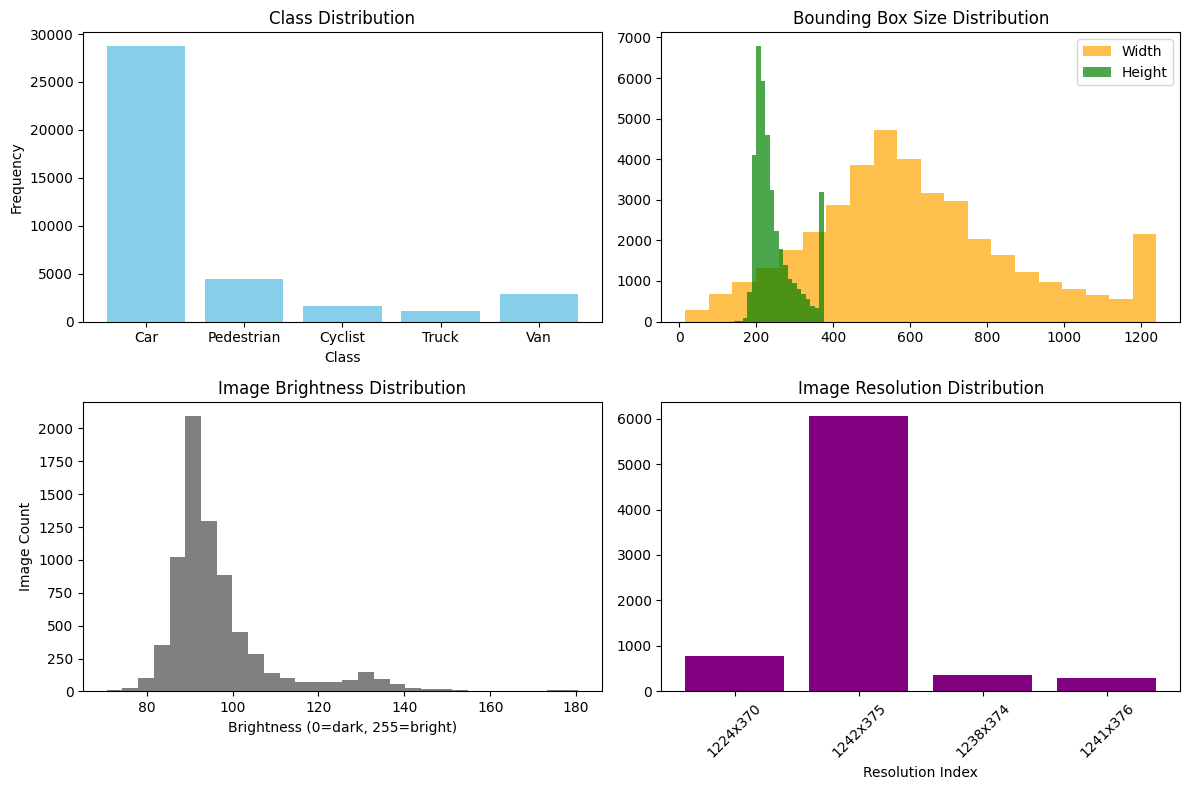

In [9]:
plt.figure(figsize=(12, 8))

# Class Distribution
plt.subplot(2, 2, 1)
plt.bar(CONFIG['classes'], [class_counts[i] for i in range(len(CONFIG['classes']))], color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Bounding Box Sizes
plt.subplot(2, 2, 2)
bbox_widths, bbox_heights = zip(*bbox_sizes) if bbox_sizes else ([], [])
plt.hist(bbox_widths, bins=20, color='orange', alpha=0.7, label='Width')
plt.hist(bbox_heights, bins=20, color='green', alpha=0.7, label='Height')
plt.title('Bounding Box Size Distribution')
plt.legend()

# Brightness Histogram
plt.subplot(2, 2, 3)
plt.hist(brightness_scores, bins=30, color='gray')
plt.title('Image Brightness Distribution')
plt.xlabel('Brightness (0=dark, 255=bright)')
plt.ylabel('Image Count')

# Image Resolution Distribution
plt.subplot(2, 2, 4)
shape_counts = Counter(image_shapes)
plt.bar(range(len(shape_counts)), [v for _, v in shape_counts.items()], color='purple')
plt.title('Image Resolution Distribution')
plt.xlabel('Resolution Index')
plt.xticks(range(len(shape_counts)), [f'{k[0]}x{k[1]}' for k in shape_counts.keys()], rotation=45)

plt.tight_layout()
plt.savefig('/kaggle/working/dataset_exploration.png')
plt.show()
plt.close()

## Generate Exploration Reports

### Main Dataset Report

This table summarizes key metrics collected during dataset exploration, including:
- Total number of images
- Count of training and validation images
- Number of missing or corrupted label files
- Brightness statistics (mean, standard deviation, min, max)

It provides a high-level overview of the dataset quality and structure.

In [10]:
# Main report
report_df = pd.DataFrame({
    'Metric': [
        'Total Images',
        'Training Images',
        'Validation Images',
        'Missing Labels',
        'Corrupted Images',
        'Brightness Mean',
        'Brightness Std',
        'Brightness Min',
        'Brightness Max'
    ],
    'Value': [
        len(image_files),
        len(train_files),
        len(val_files),
        len(missing_labels),
        len(corrupted_images),
        round(np.mean(brightness_scores), 2),
        round(np.std(brightness_scores), 2),
        round(np.min(brightness_scores), 2),
        round(np.max(brightness_scores), 2)
    ]
})

report_df

Metric    Value
0       Total Images  7481.00
1    Training Images  5984.00
2  Validation Images  1497.00
3     Missing Labels     0.00
4   Corrupted Images     0.00
5    Brightness Mean    96.96
6     Brightness Std    13.37
7     Brightness Min    70.71
8     Brightness Max   180.46

### Object Class Distribution

This table displays how frequently each object class appears in the dataset labels.
It helps assess whether the dataset suffers from class imbalance, which can affect training performance and bias.

In [11]:
class_dist_df = pd.DataFrame({
    'Class': [CONFIG['classes'][k] for k in class_counts.keys()],
    'Count': list(class_counts.values())
})

class_dist_df

Class  Count
0  Pedestrian   4487
1       Truck   1094
2         Car  28742
3     Cyclist   1627
4         Van   2914

### Image Resolution Distribution

This table shows the frequency of different image resolutions found in the dataset.
Most KITTI images share a standard resolution, but checking for outliers ensures consistency during training.


In [12]:
res_dist_df = pd.DataFrame({
    'Resolution': [f'{res[0]}x{res[1]}' for res in shape_counts.keys()],
    'Count': list(shape_counts.values())
})

res_dist_df

Resolution  Count
0   1224x370    770
1   1242x375   6057
2   1238x374    358
3   1241x376    296

# Model Training and Evaluation

## Create Dataset Configuration YAML
Generates a `dataset.yaml` file required by YOLOv11, describing the training and validation directories and class names.


In [13]:
# Create dataset.yaml
dataset_yaml = {
    'path': CONFIG['output_path'],
    'train': 'images/train',
    'val': 'images/val',
    'names': {i: name for i, name in enumerate(CONFIG['classes'])},
}
with open('/kaggle/working/dataset.yaml', 'w') as f:
    yaml.dump(dataset_yaml, f)

## Train YOLOv11 Model
Use the Ultralytics `YOLO` class to train a YOLOv11 model with defined parameters such as batch size, epochs, and learning rate scheduler. Mixed precision and cosine LR are enabled for efficiency.

In [14]:
# Model training
model = YOLO('yolo11s.pt')
model.train(
    data='/kaggle/working/dataset.yaml',
    epochs=CONFIG['epochs'],
    batch=CONFIG['batch_size'],
    imgsz=CONFIG['img_size'],
    name='yolov11s_kitti',
    patience=8,  # Early stopping
    amp=True,  # Mixed precision
    cos_lr=True,  # Cosine learning rate scheduler
    save_period=5,  # Save checkpoint every 5 epochs
)

100%|██████████| 18.4M/18.4M [00:00<00:00, 170MB/s]


Ultralytics 8.3.130 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11s_kitti, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=8, perspective=0.0, plots=True, po

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3101.8±1381.7 MB/s, size: 801.3 KB)


train: Scanning /kaggle/working/yolo_dataset/labels/train... 5984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5984/5984 [00:38<00:00, 156.62it/s]


train: New cache created: /kaggle/working/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2321.1±1377.9 MB/s, size: 815.8 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:09<00:00, 162.16it/s]

val: New cache created: /kaggle/working/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/yolov11s_kitti/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2025/05/09 14:27:23 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.
2025/05/09 14:27:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/05/09 14:27:25 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/05/09 14:27:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(74bcf86fce7c4d0c908a058ed831ae3b) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to runs/detect/yolov11s_kitti
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.93G      1.333      1.191      1.033        178        416: 100%|██████████| 374/374 [01:22<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.93it/s]

                   all       1497       7631      0.595        0.5      0.525      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.94G      1.266     0.9039     0.9963        136        416: 100%|██████████| 374/374 [01:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.31it/s]

                   all       1497       7631      0.635      0.516      0.559      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.94G      1.307     0.9289      1.011        170        416: 100%|██████████| 374/374 [01:16<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.60it/s]


                   all       1497       7631       0.66      0.449      0.503      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.94G      1.347     0.9566       1.03        172        416: 100%|██████████| 374/374 [01:16<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.51it/s]


                   all       1497       7631       0.62      0.465      0.523      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.94G      1.305     0.9076       1.02        216        416: 100%|██████████| 374/374 [01:16<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.37it/s]


                   all       1497       7631      0.607      0.499      0.537      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.94G      1.252     0.8613      1.002        171        416: 100%|██████████| 374/374 [01:16<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.58it/s]


                   all       1497       7631      0.651       0.52      0.574      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.94G       1.22     0.8293     0.9893        190        416: 100%|██████████| 374/374 [01:16<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


                   all       1497       7631      0.618       0.53      0.566       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      1.94G      1.203     0.8016     0.9844        209        416: 100%|██████████| 374/374 [01:16<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.29it/s]


                   all       1497       7631      0.697      0.551      0.614      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      1.94G       1.17     0.7806     0.9733        144        416: 100%|██████████| 374/374 [01:16<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.57it/s]


                   all       1497       7631      0.723      0.572      0.639      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.94G      1.149     0.7602     0.9711        248        416: 100%|██████████| 374/374 [01:16<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.55it/s]


                   all       1497       7631      0.727       0.56      0.622      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.94G      1.129     0.7474     0.9622        130        416: 100%|██████████| 374/374 [01:16<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.42it/s]


                   all       1497       7631        0.8      0.566      0.654      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.94G      1.119     0.7314     0.9617        178        416: 100%|██████████| 374/374 [01:15<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.58it/s]

                   all       1497       7631       0.78      0.611      0.688      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      1.94G      1.098     0.7173     0.9544        138        416: 100%|██████████| 374/374 [01:16<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.56it/s]

                   all       1497       7631       0.77      0.604      0.679       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.94G      1.094     0.7103     0.9535        187        416: 100%|██████████| 374/374 [01:16<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


                   all       1497       7631      0.765      0.618      0.697      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      1.94G      1.082     0.6956     0.9449        160        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.50it/s]


                   all       1497       7631       0.74      0.609      0.668      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.94G      1.072     0.6886     0.9427        155        416: 100%|██████████| 374/374 [01:15<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


                   all       1497       7631      0.783      0.637      0.714      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.94G       1.06     0.6777     0.9396        202        416: 100%|██████████| 374/374 [01:16<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.46it/s]

                   all       1497       7631      0.781      0.612      0.696      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.94G      1.055     0.6702     0.9395        167        416: 100%|██████████| 374/374 [01:15<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.54it/s]


                   all       1497       7631      0.817      0.621      0.713      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.94G      1.034     0.6543     0.9331        148        416: 100%|██████████| 374/374 [01:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.70it/s]


                   all       1497       7631      0.828      0.623      0.715      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.94G      1.034     0.6523     0.9333        179        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.50it/s]

                   all       1497       7631        0.8      0.662      0.732      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.94G      1.027     0.6459     0.9311        144        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.67it/s]


                   all       1497       7631      0.821      0.645      0.739      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.94G      1.016     0.6354      0.926        179        416: 100%|██████████| 374/374 [01:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.62it/s]


                   all       1497       7631      0.828      0.666      0.759      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.94G      1.012     0.6327     0.9237        111        416: 100%|██████████| 374/374 [01:15<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.56it/s]


                   all       1497       7631      0.808      0.676      0.755      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.94G      1.005     0.6273     0.9235        195        416: 100%|██████████| 374/374 [01:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.70it/s]


                   all       1497       7631      0.788      0.668      0.742      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.94G      0.989     0.6144     0.9189        180        416: 100%|██████████| 374/374 [01:16<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.61it/s]


                   all       1497       7631      0.816      0.697      0.774      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.94G     0.9839     0.6145     0.9178        153        416: 100%|██████████| 374/374 [01:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.33it/s]

                   all       1497       7631      0.827      0.694      0.775      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.94G     0.9777      0.605     0.9176        188        416: 100%|██████████| 374/374 [01:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.70it/s]


                   all       1497       7631      0.845        0.7      0.788      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      1.94G     0.9737     0.6036     0.9168        149        416: 100%|██████████| 374/374 [01:16<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.62it/s]


                   all       1497       7631      0.835      0.691      0.776      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.94G     0.9594     0.5924     0.9097        139        416: 100%|██████████| 374/374 [01:15<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.33it/s]


                   all       1497       7631       0.84      0.712       0.79      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.94G     0.9554     0.5895     0.9117        180        416: 100%|██████████| 374/374 [01:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.73it/s]


                   all       1497       7631      0.834      0.718      0.789      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.94G     0.9477     0.5831     0.9077        225        416: 100%|██████████| 374/374 [01:16<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.62it/s]


                   all       1497       7631      0.849      0.718        0.8      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      1.94G     0.9512     0.5865     0.9094        173        416: 100%|██████████| 374/374 [01:16<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.39it/s]


                   all       1497       7631      0.856      0.714      0.801      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.94G      0.938     0.5785     0.9073        161        416: 100%|██████████| 374/374 [01:15<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.58it/s]


                   all       1497       7631      0.848      0.725      0.804      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.94G     0.9251     0.5672     0.9024        135        416: 100%|██████████| 374/374 [01:16<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.59it/s]

                   all       1497       7631       0.86      0.715        0.8      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.94G     0.9269     0.5661     0.9027        172        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.33it/s]

                   all       1497       7631       0.85      0.725      0.807      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.94G     0.9222     0.5607     0.9001        155        416: 100%|██████████| 374/374 [01:15<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.59it/s]


                   all       1497       7631       0.84      0.738      0.819      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.94G      0.913     0.5566     0.8969        222        416: 100%|██████████| 374/374 [01:16<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


                   all       1497       7631      0.872      0.721      0.819      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.94G     0.9102      0.554     0.8991        168        416: 100%|██████████| 374/374 [01:16<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.33it/s]


                   all       1497       7631      0.871       0.74      0.822      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.94G      0.909     0.5529     0.8966        112        416: 100%|██████████| 374/374 [01:16<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.58it/s]


                   all       1497       7631      0.849      0.749      0.822      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.94G     0.9034      0.549     0.8959        185        416: 100%|██████████| 374/374 [01:16<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.61it/s]


                   all       1497       7631      0.862       0.75      0.825      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.94G      0.889     0.5366     0.8915        173        416: 100%|██████████| 374/374 [01:16<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.61it/s]

                   all       1497       7631       0.86      0.738      0.823      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.94G     0.8887     0.5391     0.8929        158        416: 100%|██████████| 374/374 [01:15<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.40it/s]

                   all       1497       7631       0.87      0.745      0.826       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.94G     0.8826     0.5333     0.8913        182        416: 100%|██████████| 374/374 [01:16<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.70it/s]


                   all       1497       7631      0.856      0.758       0.83      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.94G     0.8878     0.5357     0.8909        142        416: 100%|██████████| 374/374 [01:16<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.57it/s]

                   all       1497       7631      0.866       0.76      0.838      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.94G     0.8815     0.5322      0.888        176        416: 100%|██████████| 374/374 [01:16<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.32it/s]


                   all       1497       7631      0.884      0.743      0.833      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.94G     0.8672     0.5241     0.8865        136        416: 100%|██████████| 374/374 [01:16<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.63it/s]

                   all       1497       7631      0.886      0.749      0.836      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.94G     0.8641     0.5228     0.8888        214        416: 100%|██████████| 374/374 [01:16<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.64it/s]

                   all       1497       7631      0.871      0.766      0.841      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.94G     0.8574     0.5149     0.8845        194        416: 100%|██████████| 374/374 [01:16<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.26it/s]


                   all       1497       7631      0.878      0.768      0.845       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.94G     0.8543     0.5121     0.8843        159        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.67it/s]


                   all       1497       7631      0.863      0.783      0.851      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.94G     0.8537     0.5125      0.883        194        416: 100%|██████████| 374/374 [01:16<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


                   all       1497       7631      0.878      0.774      0.852      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.94G     0.8476     0.5078     0.8812        113        416: 100%|██████████| 374/374 [01:14<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.38it/s]

                   all       1497       7631      0.886      0.772      0.852      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.94G     0.8417     0.5038      0.879        150        416: 100%|██████████| 374/374 [01:15<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


                   all       1497       7631      0.881      0.771      0.854      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.94G     0.8389     0.4994     0.8789        205        416: 100%|██████████| 374/374 [01:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.67it/s]

                   all       1497       7631      0.887      0.768      0.851      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.94G     0.8292     0.4952     0.8783        181        416: 100%|██████████| 374/374 [01:15<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.32it/s]

                   all       1497       7631      0.883      0.778      0.851      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.94G      0.831     0.4992     0.8774        127        416: 100%|██████████| 374/374 [01:16<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.64it/s]

                   all       1497       7631      0.884      0.788       0.86      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      1.94G     0.8245     0.4935     0.8758        153        416: 100%|██████████| 374/374 [01:16<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


                   all       1497       7631      0.892      0.778      0.855      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      1.94G     0.8198     0.4887     0.8745        169        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.36it/s]

                   all       1497       7631      0.881      0.789      0.859      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.94G     0.8161     0.4863      0.875        174        416: 100%|██████████| 374/374 [01:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.72it/s]

                   all       1497       7631      0.907      0.765      0.859      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      1.94G     0.8084     0.4826     0.8721        213        416: 100%|██████████| 374/374 [01:15<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.63it/s]


                   all       1497       7631      0.912      0.774      0.862      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.94G     0.8042     0.4795     0.8688        181        416: 100%|██████████| 374/374 [01:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.44it/s]

                   all       1497       7631      0.904      0.784      0.867      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.94G      0.804     0.4801     0.8711        146        416: 100%|██████████| 374/374 [01:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


                   all       1497       7631      0.907      0.779       0.87      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.94G     0.7967     0.4743     0.8678        144        416: 100%|██████████| 374/374 [01:15<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.49it/s]


                   all       1497       7631      0.884        0.8      0.869      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.94G      0.795     0.4705     0.8694        218        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.55it/s]

                   all       1497       7631      0.898      0.797      0.874      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.94G     0.7909      0.468     0.8675        171        416: 100%|██████████| 374/374 [01:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.65it/s]


                   all       1497       7631      0.906      0.795      0.871      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.94G     0.7833     0.4642     0.8681        141        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.49it/s]


                   all       1497       7631      0.891      0.805      0.877      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.94G     0.7787     0.4607      0.865        114        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.54it/s]

                   all       1497       7631      0.892      0.806      0.874       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.94G     0.7817     0.4635     0.8651        135        416: 100%|██████████| 374/374 [01:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.71it/s]


                   all       1497       7631      0.901      0.798      0.875      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.94G     0.7716     0.4584     0.8627        204        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.44it/s]


                   all       1497       7631      0.906      0.801      0.876      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.94G      0.766     0.4527     0.8602        127        416: 100%|██████████| 374/374 [01:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


                   all       1497       7631      0.885      0.813      0.875      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.94G     0.7649     0.4496     0.8614        134        416: 100%|██████████| 374/374 [01:16<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.62it/s]


                   all       1497       7631      0.895      0.805      0.877      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.94G     0.7554      0.447     0.8592        144        416: 100%|██████████| 374/374 [01:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.31it/s]


                   all       1497       7631      0.891      0.811       0.88      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.94G     0.7524     0.4445     0.8606        182        416: 100%|██████████| 374/374 [01:14<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


                   all       1497       7631      0.906      0.796      0.876       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.94G     0.7488     0.4428      0.858        163        416: 100%|██████████| 374/374 [01:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.68it/s]

                   all       1497       7631       0.89       0.81       0.88      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.94G     0.7448     0.4388     0.8584        157        416: 100%|██████████| 374/374 [01:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.47it/s]


                   all       1497       7631      0.906       0.81      0.884      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.94G     0.7417     0.4373     0.8558        167        416: 100%|██████████| 374/374 [01:14<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.74it/s]


                   all       1497       7631      0.904      0.814      0.882      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.94G     0.7385     0.4361     0.8565        128        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


                   all       1497       7631        0.9      0.813      0.881       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120      1.94G     0.7356     0.4355     0.8535        154        416: 100%|██████████| 374/374 [01:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.43it/s]

                   all       1497       7631      0.899      0.809      0.881      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.94G     0.7303     0.4319     0.8546        110        416: 100%|██████████| 374/374 [01:14<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.73it/s]


                   all       1497       7631      0.909      0.807      0.884      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.94G     0.7333     0.4307     0.8559        149        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.49it/s]

                   all       1497       7631      0.895      0.812      0.884      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.94G     0.7216      0.427     0.8512        181        416: 100%|██████████| 374/374 [01:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.71it/s]


                   all       1497       7631      0.919      0.798      0.884      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.94G     0.7217     0.4245     0.8521        238        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


                   all       1497       7631      0.893      0.808      0.883      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.94G     0.7161     0.4237     0.8527        194        416: 100%|██████████| 374/374 [01:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.47it/s]


                   all       1497       7631      0.906      0.802      0.881      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      1.94G     0.7101     0.4195       0.85        199        416: 100%|██████████| 374/374 [01:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.70it/s]


                   all       1497       7631      0.925      0.801      0.887      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.94G     0.7065     0.4166     0.8486        103        416: 100%|██████████| 374/374 [01:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.73it/s]


                   all       1497       7631      0.913      0.813      0.889      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.94G     0.7057     0.4166     0.8488        138        416: 100%|██████████| 374/374 [01:14<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.44it/s]

                   all       1497       7631      0.914      0.812      0.888      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.94G      0.703     0.4146      0.849        113        416: 100%|██████████| 374/374 [01:14<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.73it/s]


                   all       1497       7631      0.917      0.813       0.89       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120      1.94G        0.7     0.4139      0.848        166        416: 100%|██████████| 374/374 [01:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.70it/s]


                   all       1497       7631      0.917      0.816       0.89      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.94G     0.6951     0.4099     0.8469        164        416: 100%|██████████| 374/374 [01:14<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.49it/s]


                   all       1497       7631      0.908      0.819      0.888      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.94G     0.6882      0.405     0.8455        215        416: 100%|██████████| 374/374 [01:14<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


                   all       1497       7631      0.919      0.814      0.891      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      1.94G     0.6923     0.4069     0.8435        168        416: 100%|██████████| 374/374 [01:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.59it/s]

                   all       1497       7631        0.9      0.829      0.891      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120      1.94G     0.6887     0.4069     0.8437        147        416: 100%|██████████| 374/374 [01:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.80it/s]


                   all       1497       7631      0.912      0.816      0.892       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120      1.94G     0.6813     0.4008     0.8431        175        416: 100%|██████████| 374/374 [01:14<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


                   all       1497       7631      0.916      0.822      0.892      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.94G     0.6763        0.4     0.8433        135        416: 100%|██████████| 374/374 [01:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.40it/s]

                   all       1497       7631      0.918      0.825      0.893      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120      1.94G     0.6746     0.3984     0.8434        137        416: 100%|██████████| 374/374 [01:14<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.65it/s]


                   all       1497       7631      0.904      0.831      0.892      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.94G     0.6716     0.3954     0.8427        177        416: 100%|██████████| 374/374 [01:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


                   all       1497       7631      0.906      0.828      0.892      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.94G     0.6701     0.3952     0.8426        166        416: 100%|██████████| 374/374 [01:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.40it/s]


                   all       1497       7631      0.918      0.821      0.892      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.94G     0.6659      0.393     0.8419        208        416: 100%|██████████| 374/374 [01:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.74it/s]


                   all       1497       7631       0.92      0.822      0.895      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      1.94G     0.6614     0.3877     0.8384        123        416: 100%|██████████| 374/374 [01:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.64it/s]

                   all       1497       7631      0.919      0.821      0.894      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.94G     0.6618     0.3912     0.8399        185        416: 100%|██████████| 374/374 [01:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.45it/s]

                   all       1497       7631      0.919      0.821      0.895      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120      1.94G     0.6584     0.3887     0.8373        162        416: 100%|██████████| 374/374 [01:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.86it/s]


                   all       1497       7631      0.904      0.826      0.894      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.94G     0.6578     0.3884     0.8391        180        416: 100%|██████████| 374/374 [01:14<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.42it/s]


                   all       1497       7631      0.912      0.823      0.894       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.94G       0.66     0.3881     0.8392        164        416: 100%|██████████| 374/374 [01:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


                   all       1497       7631       0.91      0.825      0.895      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.36it/s]

                   all       1497       7631      0.913      0.825      0.895      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.94G     0.6514     0.3835     0.8368        200        416: 100%|██████████| 374/374 [01:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


                   all       1497       7631      0.922      0.821      0.894      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.94G     0.6489     0.3806     0.8359        163        416: 100%|██████████| 374/374 [01:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


                   all       1497       7631      0.921       0.82      0.896      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.94G     0.6436     0.3806     0.8383        186        416: 100%|██████████| 374/374 [01:14<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.44it/s]


                   all       1497       7631      0.931      0.816      0.895      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.94G     0.6434     0.3798     0.8368        187        416: 100%|██████████| 374/374 [01:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.74it/s]


                   all       1497       7631      0.931      0.814      0.895      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.94G     0.6425     0.3801     0.8368        164        416: 100%|██████████| 374/374 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


                   all       1497       7631      0.931      0.815      0.896      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.94G     0.6424     0.3773     0.8362        155        416: 100%|██████████| 374/374 [01:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.54it/s]


                   all       1497       7631      0.929      0.818      0.896      0.673
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120      1.94G     0.6446     0.3705     0.8308         68        416: 100%|██████████| 374/374 [01:15<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.71it/s]


                   all       1497       7631      0.928      0.818      0.896       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.94G     0.6196     0.3583     0.8248         95        416: 100%|██████████| 374/374 [01:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


                   all       1497       7631      0.927      0.818      0.893       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.94G     0.6133     0.3552     0.8258         87        416: 100%|██████████| 374/374 [01:14<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


                   all       1497       7631       0.92      0.818      0.892      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.94G     0.6104      0.354      0.823         75        416: 100%|██████████| 374/374 [01:14<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


                   all       1497       7631      0.919      0.816      0.892      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.94G     0.6115     0.3532     0.8247         71        416: 100%|██████████| 374/374 [01:14<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.47it/s]


                   all       1497       7631      0.918      0.818      0.893      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.94G     0.6048     0.3511     0.8212         80        416: 100%|██████████| 374/374 [01:14<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  4.78it/s]


                   all       1497       7631      0.921      0.819      0.893      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.94G      0.605     0.3504     0.8222        116        416: 100%|██████████| 374/374 [01:14<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


                   all       1497       7631      0.915      0.825      0.894      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.94G     0.6027       0.35     0.8229        108        416: 100%|██████████| 374/374 [01:14<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.64it/s]

                   all       1497       7631       0.92       0.82      0.895      0.669
EarlyStopping: Training stopped early as no improvement observed in last 8 epochs. Best results observed at epoch 110, best model saved as best.pt.
To update EarlyStopping(patience=8) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



118 epochs completed in 2.837 hours.
Optimizer stripped from runs/detect/yolov11s_kitti/weights/last.pt, 19.1MB
Optimizer stripped from runs/detect/yolov11s_kitti/weights/best.pt, 19.1MB

Validating runs/detect/yolov11s_kitti/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.06it/s]


                   all       1497       7631       0.93      0.819      0.897      0.674
                   Car       1338       5693      0.943       0.87      0.947      0.783
            Pedestrian        349        873      0.895      0.635      0.764      0.451
               Cyclist        209        292      0.913      0.771      0.867      0.565
                 Truck        208        220      0.961      0.959      0.974      0.826
                   Van        421        553      0.937      0.859      0.932      0.742


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.0ms preprocess, 1.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/yolov11s_kitti
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7956558637d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

## MLflow Tracking Setup
Configure MLflow tracking by setting the experiment name and tracking URI. This enables remote logging and versioning of training runs.


In [15]:
mlflow.set_experiment("Yolo_v11")
mlflow.set_tracking_uri("http://172.210.136.229:5001/")

2025/05/09 17:18:00 INFO mlflow.tracking.fluent: Experiment with name 'Yolo_v11' does not exist. Creating a new experiment.


## Evaluate Model
Run the evaluation pipeline to generate metrics like precision, recall, and mAP on the validation set.


In [16]:
# Model evaluation
metrics = model.val()

Ultralytics 8.3.130 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3213.9±1295.7 MB/s, size: 833.1 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:13<00:00,  7.01it/s]


                   all       1497       7631      0.929      0.819      0.898      0.675
                   Car       1338       5693      0.943       0.87      0.947      0.784
            Pedestrian        349        873      0.894      0.636      0.766      0.451
               Cyclist        209        292      0.913      0.771      0.869      0.567
                 Truck        208        220      0.959      0.959      0.974      0.828
                   Van        421        553      0.938      0.859      0.932      0.746


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/yolov11s_kitti2


## Measure FPS (Inference Speed)
Evaluate the inference speed of the model over a set number of runs to calculate Frames Per Second (FPS), indicating real-time performance capability.


In [17]:
# FPS calculation
test_image = '/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/004644.png'
num_runs = 50
start_time = time.time()
for _ in range(num_runs):
    _ = model(test_image, verbose=False)
fps = num_runs / (time.time() - start_time)
print(f'FPS: {fps}')

FPS: 33.29995639720904


## Log Metrics and Parameters to MLflow
Log training configuration, evaluation metrics, and inference performance to MLflow for experiment tracking and comparison.

In [18]:
# Uploading updates to mlflow
experiment_name = "Yolo_v11"
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = experiment.experiment_id
    
box_p = metrics.box.p.mean().item()
recall = metrics.box.r.mean().item()
map50 = metrics.box.map50.mean().item()
map_metric = metrics.box.map.mean().item()

with mlflow.start_run(experiment_id=experiment_id, run_name='Yolo_v11'):
    mlflow.log_params(CONFIG)
    mlflow.log_metrics({
        "Box_Precision": box_p,
        "Recall": recall,
        "mAP50": map50,
        "mAP50_95": map_metric,
        "FPS": fps
    })

🏃 View run Yolo_v11 at: http://172.210.136.229:5001/#/experiments/900678854628258621/runs/53f54e2c9123456e8a9da78dcde7004b
🧪 View experiment at: http://172.210.136.229:5001/#/experiments/900678854628258621


## Visualize Detection Output
Use a test image to run the trained model and display/save the prediction result for visual verification of the model's performance.



image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/004284.png: 128x416 12 Cars, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 128, 416)


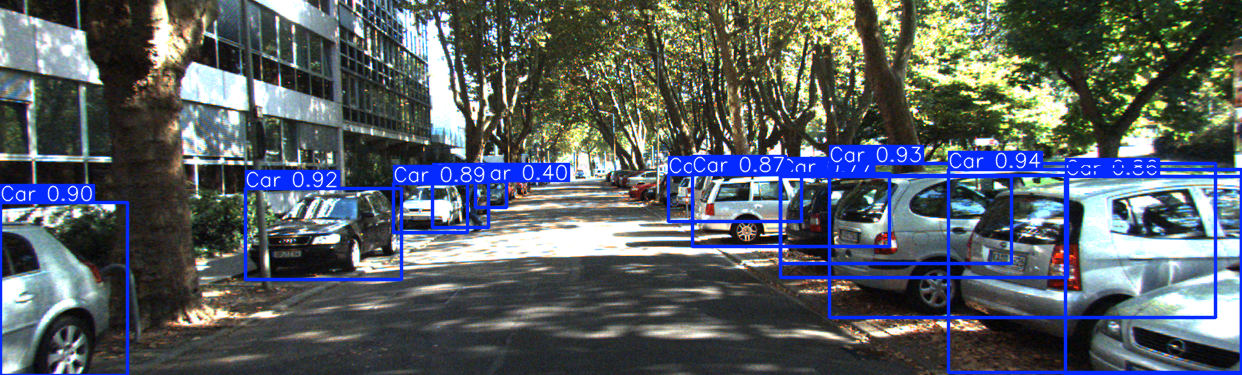

In [66]:
# Visualize results
test_image = '/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/004284.png'
results = model(test_image)
results[0].save('/kaggle/working/test_result.png')
results[0].show()


image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/006127.png: 128x416 4 Cars, 8 Pedestrians, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 416)


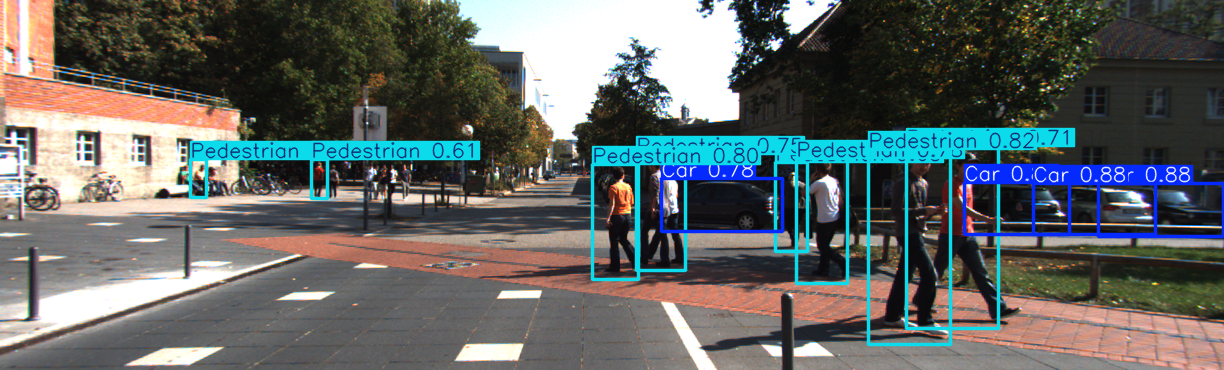

In [65]:
# Visualize results
test_image = '/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/006127.png'
results = model(test_image)
results[0].save('/kaggle/working/test_result.png')
results[0].show()


image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/004625.png: 128x416 3 Cars, 4 Pedestrians, 1 Truck, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 128, 416)


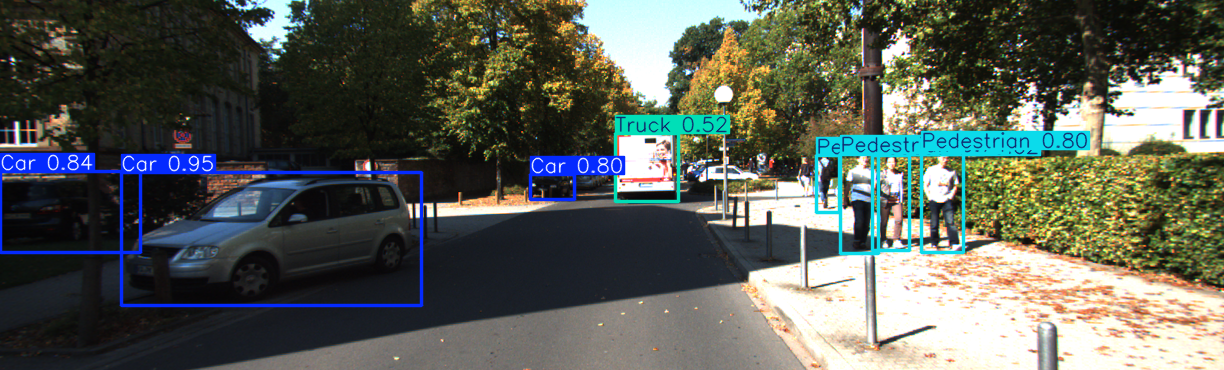

In [69]:
# Visualize results
test_image = '/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/004625.png'
results = model(test_image)
results[0].save('/kaggle/working/test_result.png')
results[0].show()

## Export Model to ONNX
Export the trained YOLOv11 model in ONNX format for deployment or further usage in production environments or other frameworks.


In [20]:
model = YOLO('/kaggle/working/runs/detect/yolov11s_kitti/weights/best.pt')  
model.export(format='onnx')

Ultralytics 8.3.130 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.00GHz)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from '/kaggle/working/runs/detect/yolov11s_kitti/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 9, 3549) (18.3 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.46', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
WARNING ⚠️ Retry 1/2 failed: Command 'pip install --no-cache-dir "onnxslim>=0.1.46" "onnxruntime-gpu" ' returned non-zero exit status 1.


ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    unknown package:
        Expected sha256 f210e613293bf939cf62b4ffa149cc4ccc5622430044e72201a058b261799eed
             Got        bf9b11c705ea50c37afe9c0339277ba5ddd2fd41b431b361aef2180bf44b0a4d



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.6/145.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 282.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 188.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 243.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 17.1s, installed 2 packages: ['onnxslim>=0.1.46', 'onnxruntime-gpu']
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.52...
ONNX: export success ✅ 20.8s, saved as '/kaggle/working/runs/detect/yolov11s_kitti/weights/best.onnx' (36.1 MB)

Export complete (23.0s)
Results saved to /kaggle/working/runs/detect/yolov11s_kitti/weights
Predict:         yolo predict task=detect model=/kaggle/working/runs/detect/yolov11s_kitti/weights/best.onnx imgsz=416  
Validate:        yolo val task=detect model=/kaggle/working/runs/detec

'/kaggle/working/runs/detect/yolov11s_kitti/weights/best.onnx'